### Galaxy-Flux correlation in bins of K

In [6]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt


def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > 1200]  
  
  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['z'] = (data['v']*u.km/u.s / c).to_value(u.one)
  mu = cosmo.distmod(data['z']).value                   # distance modulus in mag (uses D_L correctly)

  data['M_Ks'] = data['k_tc'] - mu  # - Kcorr - Aext

  data['M_Ks'] = -25 - 5 * np.log10(data['v']/100.) + data['k_tc']  

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    rand_ra = np.random.uniform(0, 360, N_total)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))
    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 50,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
gxs = read_catalog()

# Validate gxs catalog
required_columns = ['_RAJ2000', '_DEJ2000', 'cz']
for col in required_columns:
    if col not in gxs.colnames:
        raise ValueError(f"Missing required column '{col}' in galaxy catalog.")

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=10)


Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']


(array([[ 4.,  7., 11., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([ 1201.  ,  2214.26,  3227.52,  4240.78,  5254.04,  6267.3 ,
         7280.56,  8293.82,  9307.08, 10320.34, 11333.6 , 12346.86,
        13360.12, 14373.38, 15386.64, 16399.9 , 17413.16, 18426.42,
        19439.68, 20452.94, 21466.2 , 22479.46, 23492.72, 24505.98,
        25519.24, 26532.5 , 27545.76, 28559.02, 29572.28, 30585.54,
        31598.8 , 32612.06, 33625.32, 34638.58, 35651.84, 36665.1 ,
        37678.36, 38691.62, 39704.88, 40718.14, 41731.4 , 42744.66,
        43757.92, 44771.18, 45784.44, 46797.7 , 47810.96, 48824.22,
        49837.48, 50850.74, 51864.  ]),
 array([18.87075975, 19.06238556, 19.25401136, 19.44563717, 19.63726298,
        19.82888879, 20.02051459, 20.2121404 , 20.40376621

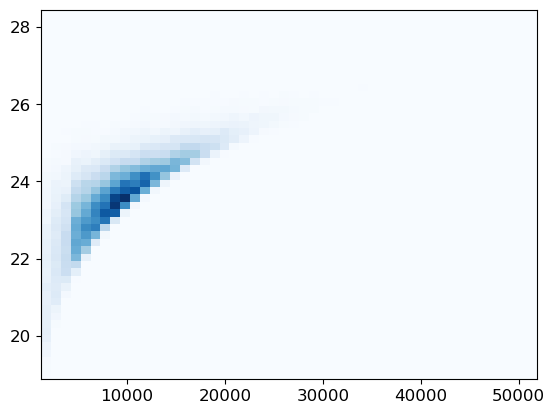

In [7]:

plt.hist2d(gxs['cz'], -gxs['M_Ks'], bins=50, cmap='Blues')

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 9.000e+00, 4.100e+01,
        9.600e+01, 1.730e+02, 3.290e+02, 4.680e+02, 7.810e+02, 1.140e+03,
        1.606e+03, 2.039e+03, 2.484e+03, 3.034e+03, 3.313e+03, 3.511e+03,
        3.509e+03, 3.451e+03, 3.159e+03, 2.750e+03, 2.244e+03, 1.942e+03,
        1.533e+03, 1.229e+03, 1.004e+03, 7.750e+02, 5.400e+02, 4.060e+02,
        2.660e+02, 2.210e+02, 1.800e+02, 1.520e+02, 1.150e+02, 9.800e+01,
        7.600e+01, 7.100e+01, 6.400e+01, 4.100e+01, 2.900e+01, 1.100e+01,
        7.000e+00, 4.000e+00]),
 array([-28.45205011, -28.2604243 , -28.06879849, -27.87717269,
        -27.68554688, -27.49392107, -27.30229527, -27.11066946,
        -26.91904365, -26.72741784, -26.53579204, -26.34416623,
        -26.15254042, -25.96091462, -25.76928881, -25.577663  ,
        -25.38603719, -25.19441139, -25.00278558, -24.81115977,
        -24.61953397, -24.42790816, -24.23628235, -24.04

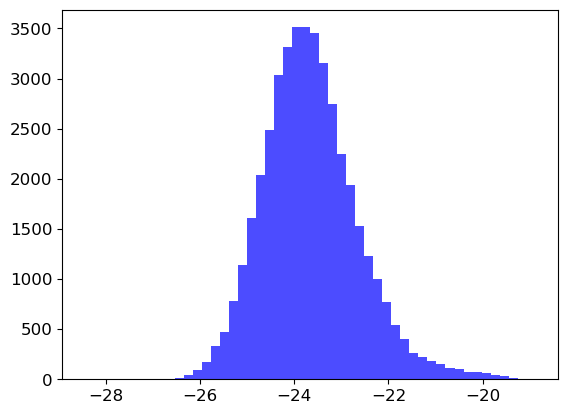

In [8]:
plt.hist(gxs['M_Ks'], bins=50, color='blue', alpha=0.7, label='M_Ks')

Processing slice: -22 -20
Processing slice: -24 -22
Processing slice: -26 -24
Processing slice: -28 -26


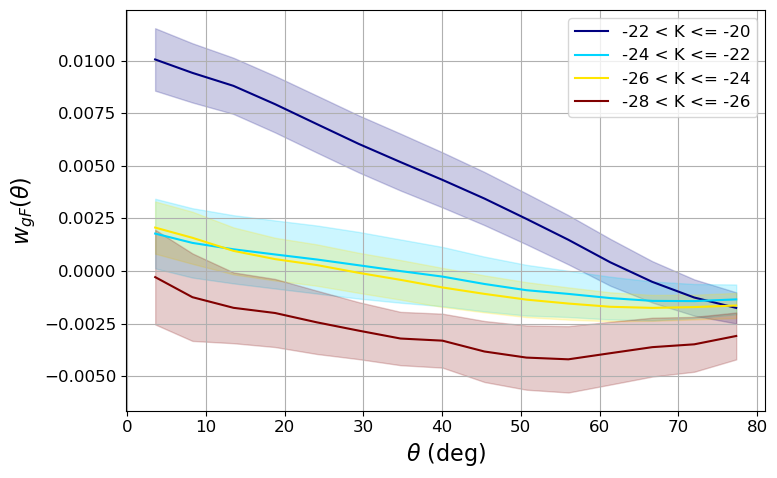

In [9]:

"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
k_slices = [(-20,-22), (-22,-24), (-24,-26), (-26,-28)]
colors = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

fig, ax = plt.subplots(figsize=(8, 5))

for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['M_Ks'] > k_min) & (gxs['M_Ks'] <= k_max)]

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value
    # Plot with color gradient
    # plt.errorbar(nk.meanr, xi/flux_val.mean(), yerr=varxi**.5, fmt='o-', color=colors[i],
    #              label=f'{cz_min} < cz <= {cz_max}')
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{k_min} < K <= {k_max}')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 18,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()